In [1]:
import pandas as pd
import numpy as np
import os
import sys

# local library
from rinex3 import readRinex3NavFile, readNavDataFromOneFile

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

## Read data files

In [3]:
#filename template
#fnav = 'ftp://ftp.cddis.eosdis.nasa.gov/gnss/data/daily/2019/{n}/19p/BRDC00IGS_R_2019{n}0000_01D_MN.rnx.gz'
fnav = 'C:/cygwin64/home/oan/grc/brdc/BRDC00IGS_R_2019{n}0000_01D_MN.rnx.gz'

# list of files
FILES = [fnav.format(n='{:03d}'.format(doy)) for doy in np.arange(1,255)]
len(FILES), FILES[-1]

(254, 'C:/cygwin64/home/oan/grc/brdc/BRDC00IGS_R_20192540000_01D_MN.rnx.gz')

(254, 'C:/cygwin64/home/oan/grc/brdc/BRDC00IGS_R_20192540000_01D_MN.rnx.gz')

In [4]:
%%time
# read all files into individual frame and concatenate all of them into one single frame
dNAV=pd.concat([readNavDataFromOneFile(file, satsys='E') for file in FILES[:]]).reset_index(drop=True)

readNavDataFromOneFile: C:/cygwin64/home/oan/grc/brdc/BRDC00IGS_R_20190830000_01D_MN.rnx.gz
readNavDataFromOneFile: C:/cygwin64/home/oan/grc/brdc/BRDC00IGS_R_20190830000_01D_MN.rnx.gz
readNavDataFromOneFile: C:/cygwin64/home/oan/grc/brdc/BRDC00IGS_R_20190870000_01D_MN.rnx.gz
readNavDataFromOneFile: C:/cygwin64/home/oan/grc/brdc/BRDC00IGS_R_20190870000_01D_MN.rnx.gz
readNavDataFromOneFile: C:/cygwin64/home/oan/grc/brdc/BRDC00IGS_R_20191140000_01D_MN.rnx.gz
readNavDataFromOneFile: C:/cygwin64/home/oan/grc/brdc/BRDC00IGS_R_20191140000_01D_MN.rnx.gz
Wall time: 12min 38s
Wall time: 12min 38s


In [5]:
# make a copy of the frame just in case
# Z=dNAV.copy()

In [6]:
# How many messages?
dNAV.shape

(2032189, 42)

(2032189, 42)

In [7]:
# What is the covered period?
print('A:', dNAV['TOC'].sort_values().iloc[0], dNAV['TOC'].sort_values().iloc[-1])

A: 2019-01-01 00:00:00 2019-09-11 23:40:00
A: 2019-01-01 00:00:00 2019-09-11 23:40:00


In [8]:
# just to be sure there is no other message types
mask = dNAV[27].isin([258, 513, 516, 517])
dNAV = dNAV[mask]
print(dNAV[~mask].shape)

(0, 42)
(0, 42)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [9]:
# add additional columns
dNAV['DIFF']=dNAV.apply(lambda x: (x.TOE-x.TTOM).total_seconds(), axis=1) # after or before?
dNAV['MONTH']=dNAV.set_index('TOC').index.month


## Visualisation

### TOE < TTOM

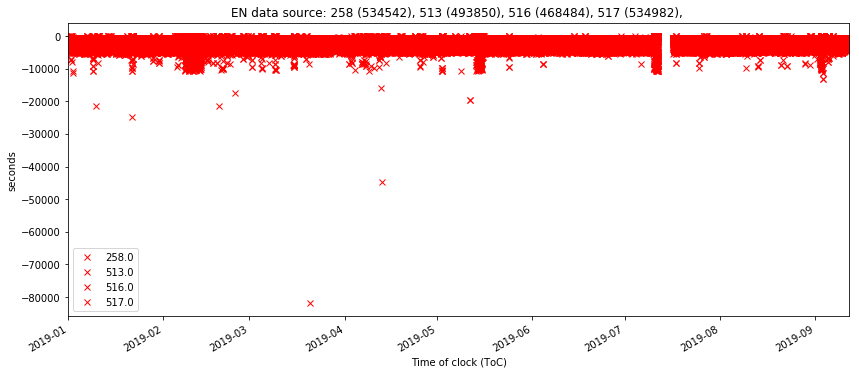

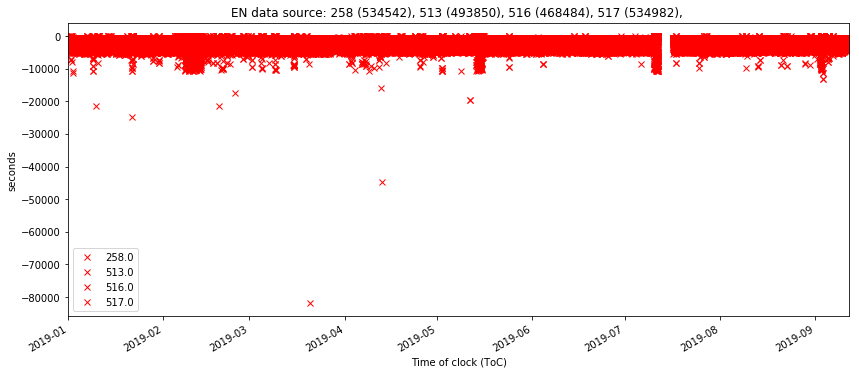

In [10]:
# all sources together
fig, ax = plt.subplots(figsize=(14,6))

mask = dNAV['DIFF']>0
title = 'EN data source: '
X=dNAV[~mask].set_index('TOC')[[27, 'DIFF']].groupby(27)
for key, group in X:
    group.plot(ax=ax, y='DIFF', marker='x', linestyle='None', color='r', label=key)
    title += '{} ({}), '.format(int(key), group.shape[0])

ax.legend(labels=X.groups.keys())
ax.set(title=title, ylabel='seconds', xlabel='Time of clock (ToC)');


In [11]:
# stats by month for the TOE < TTOM
dNAV[~mask].groupby(['MONTH', 27])['DIFF'].describe()

count        mean         std      min    25%    50%    75%  \
MONTH 27                                                                     
1     258.0  68852.0 -820.332162  352.806176 -10680.0 -740.0 -740.0 -740.0   
      513.0  62055.0 -749.084667  314.067807 -10765.0 -685.0 -685.0 -666.0   
      516.0  53571.0 -750.581677  260.239054 -10654.0 -694.0 -694.0 -694.0   
      517.0  68815.0 -752.219138  387.289020 -24897.0 -666.0 -665.0 -665.0   
2     258.0  59253.0 -819.407456  417.588204 -10740.0 -740.0 -740.0 -740.0   
      513.0  57061.0 -750.481450  388.285208 -17637.0 -685.0 -685.0 -666.0   
      516.0  52960.0 -752.524981  322.951497 -10534.0 -694.0 -694.0 -694.0   
      517.0  59392.0 -751.746414  437.991899 -21426.0 -665.0 -665.0 -665.0   
3     258.0  63000.0 -820.071746  341.677213 -10390.0 -740.0 -740.0 -740.0   
      513.0  45629.0 -767.997633  530.308883 -81805.0 -685.0 -685.0 -664.0   
      516.0  37803.0 -776.306880  351.517280  -9694.0 -694.0 -694.0 -694.0   
      517.0  62910.0 -751.421348  355.579772 -10407.0 -665.0 -665.0 -665.0   
4     258.0  64961.0 -811.211188  380.263385 -44830.0 -740.0 -740.0 -740.0   
      513.0  55731.0 -761.862088  343.107661  -8605.0 -685.0 -685.0 -685.0   
      516.0  52670.0 -768.803550  337.284090  -8074.0 -694.0 -694.0 -694.0   
      517.0  65371.0 -741.419697  335.627592 -15894.0 -665.0 -665.0 -665.0   
5     258.0  70319.0 -806.323184  344.063254 -10630.0 -740.0 -740.0 -740.0   
      513.0  68479.0 -750.588881  351.196384 -19705.0 -685.0 -685.0 -685.0   
      516.0  67712.0 -757.869270  338.637473 -19714.0 -694.0 -694.0 -694.0   
      517.0  70321.0 -736.479885  345.674800 -10767.0 -665.0 -665.0 -665.0   
6     258.0  67310.0 -808.552370  315.907231  -8730.0 -740.0 -740.0 -730.0   
      513.0  64581.0 -756.979808  324.622810  -8725.0 -685.0 -685.0 -685.0   
      516.0  64463.0 -761.269659  310.671111  -8734.0 -694.0 -694.0 -694.0   
      517.0  67323.0 -739.022830  311.810315  -6027.0 -665.0 -665.0 -665.0   
7     258.0  54247.0 -835.287297  420.338232 -10730.0 -740.0 -740.0 -740.0   
      513.0  54215.0 -768.878668  375.449244 -10525.0 -685.0 -685.0 -685.0   
      516.0  54233.0 -771.654767  339.875947 -10114.0 -694.0 -694.0 -694.0   
      517.0  54247.0 -766.810146  432.992454 -10797.0 -665.0 -665.0 -665.0   
8     258.0  64280.0 -822.696484  317.417969  -9250.0 -740.0 -740.0 -740.0   
      513.0  64266.0 -774.256777  351.929859  -9325.0 -685.0 -685.0 -685.0   
      516.0  64285.0 -779.590838  333.347158  -9694.0 -694.0 -694.0 -694.0   
      517.0  64284.0 -752.765836  324.034310  -9636.0 -666.0 -666.0 -665.0   
9     258.0  22320.0 -828.845430  395.169438 -13230.0 -740.0 -740.0 -740.0   
      513.0  21833.0 -784.439106  411.770141 -11365.0 -685.0 -685.0 -685.0   
      516.0  20787.0 -786.554481  395.527188 -11374.0 -694.0 -694.0 -694.0   
      517.0  22319.0 -760.406828  406.832856 -13197.0 -666.0 -666.0 -665.0   

              max  
MONTH 27           
1     258.0 -40.0  
      513.0  -4.0  
      516.0  -4.0  
      517.0  -5.0  
2     258.0   0.0  
      513.0  -4.0  
      516.0 -34.0  
      517.0  -5.0  
3     258.0 -30.0  
      513.0  -4.0  
      516.0 -34.0  
      517.0  -5.0  
4     258.0 -30.0  
      513.0 -25.0  
      516.0 -34.0  
      517.0  -5.0  
5     258.0 -30.0  
      513.0  -4.0  
      516.0  -4.0  
      517.0  -5.0  
6     258.0 -30.0  
      513.0 -25.0  
      516.0 -34.0  
      517.0  -5.0  
7     258.0 -30.0  
      513.0  -4.0  
      516.0  -4.0  
      517.0  -5.0  
8     258.0   0.0  
      513.0  -4.0  
      516.0 -34.0  
      517.0  -5.0  
9     258.0 -30.0  
      513.0  -6.0  
      516.0 -34.0  
      517.0  -5.0

count        mean         std      min    25%    50%    75%  \
MONTH 27                                                                     
1     258.0  68852.0 -820.332162  352.806176 -10680.0 -740.0 -740.0 -740.0   
      513.0  62055.0 -749.084667  314.067807 -10765.0 -685.0 -685.0 -666.0   
      516.0  53571.0 -750.581677  260.239054 -10654.0 -694.0 -694.0 -694.0   
      517.0  68815.0 -752.219138  387.289020 -24897.0 -666.0 -665.0 -665.0   
2     258.0  59253.0 -819.407456  417.588204 -10740.0 -740.0 -740.0 -740.0   
      513.0  57061.0 -750.481450  388.285208 -17637.0 -685.0 -685.0 -666.0   
      516.0  52960.0 -752.524981  322.951497 -10534.0 -694.0 -694.0 -694.0   
      517.0  59392.0 -751.746414  437.991899 -21426.0 -665.0 -665.0 -665.0   
3     258.0  63000.0 -820.071746  341.677213 -10390.0 -740.0 -740.0 -740.0   
      513.0  45629.0 -767.997633  530.308883 -81805.0 -685.0 -685.0 -664.0   
      516.0  37803.0 -776.306880  351.517280  -9694.0 -694.0 -694.0 -694.0   
      517.0  62910.0 -751.421348  355.579772 -10407.0 -665.0 -665.0 -665.0   
4     258.0  64961.0 -811.211188  380.263385 -44830.0 -740.0 -740.0 -740.0   
      513.0  55731.0 -761.862088  343.107661  -8605.0 -685.0 -685.0 -685.0   
      516.0  52670.0 -768.803550  337.284090  -8074.0 -694.0 -694.0 -694.0   
      517.0  65371.0 -741.419697  335.627592 -15894.0 -665.0 -665.0 -665.0   
5     258.0  70319.0 -806.323184  344.063254 -10630.0 -740.0 -740.0 -740.0   
      513.0  68479.0 -750.588881  351.196384 -19705.0 -685.0 -685.0 -685.0   
      516.0  67712.0 -757.869270  338.637473 -19714.0 -694.0 -694.0 -694.0   
      517.0  70321.0 -736.479885  345.674800 -10767.0 -665.0 -665.0 -665.0   
6     258.0  67310.0 -808.552370  315.907231  -8730.0 -740.0 -740.0 -730.0   
      513.0  64581.0 -756.979808  324.622810  -8725.0 -685.0 -685.0 -685.0   
      516.0  64463.0 -761.269659  310.671111  -8734.0 -694.0 -694.0 -694.0   
      517.0  67323.0 -739.022830  311.810315  -6027.0 -665.0 -665.0 -665.0   
7     258.0  54247.0 -835.287297  420.338232 -10730.0 -740.0 -740.0 -740.0   
      513.0  54215.0 -768.878668  375.449244 -10525.0 -685.0 -685.0 -685.0   
      516.0  54233.0 -771.654767  339.875947 -10114.0 -694.0 -694.0 -694.0   
      517.0  54247.0 -766.810146  432.992454 -10797.0 -665.0 -665.0 -665.0   
8     258.0  64280.0 -822.696484  317.417969  -9250.0 -740.0 -740.0 -740.0   
      513.0  64266.0 -774.256777  351.929859  -9325.0 -685.0 -685.0 -685.0   
      516.0  64285.0 -779.590838  333.347158  -9694.0 -694.0 -694.0 -694.0   
      517.0  64284.0 -752.765836  324.034310  -9636.0 -666.0 -666.0 -665.0   
9     258.0  22320.0 -828.845430  395.169438 -13230.0 -740.0 -740.0 -740.0   
      513.0  21833.0 -784.439106  411.770141 -11365.0 -685.0 -685.0 -685.0   
      516.0  20787.0 -786.554481  395.527188 -11374.0 -694.0 -694.0 -694.0   
      517.0  22319.0 -760.406828  406.832856 -13197.0 -666.0 -666.0 -665.0   

              max  
MONTH 27           
1     258.0 -40.0  
      513.0  -4.0  
      516.0  -4.0  
      517.0  -5.0  
2     258.0   0.0  
      513.0  -4.0  
      516.0 -34.0  
      517.0  -5.0  
3     258.0 -30.0  
      513.0  -4.0  
      516.0 -34.0  
      517.0  -5.0  
4     258.0 -30.0  
      513.0 -25.0  
      516.0 -34.0  
      517.0  -5.0  
5     258.0 -30.0  
      513.0  -4.0  
      516.0  -4.0  
      517.0  -5.0  
6     258.0 -30.0  
      513.0 -25.0  
      516.0 -34.0  
      517.0  -5.0  
7     258.0 -30.0  
      513.0  -4.0  
      516.0  -4.0  
      517.0  -5.0  
8     258.0   0.0  
      513.0  -4.0  
      516.0 -34.0  
      517.0  -5.0  
9     258.0 -30.0  
      513.0  -6.0  
      516.0 -34.0  
      517.0  -5.0

In [12]:
# stats by month for TOE > TTOM
dNAV[mask].groupby(['MONTH', 27])['DIFF'].describe()

count          mean           std      min       25%      50%  \
MONTH 27                                                                     
1     513.0   60.0  42362.500000  29711.511478      5.0  20531.00  36911.0   
      516.0    7.0  29248.571429  24574.508526   1166.0  18731.00  21896.0   
2     513.0   53.0  37584.981132  32083.711998      5.0   1496.00  36206.0   
      516.0    7.0  48926.000000  21348.465987  21836.0  37406.00  45986.0   
      517.0    2.0  78206.000000   1145.512986  77396.0  77801.00  78206.0   
3     513.0   38.0  54261.578947  32256.555246   2585.0  26270.75  44081.0   
      516.0    5.0  44306.000000  21079.552889  25886.0  26036.00  45386.0   
      517.0    2.0  48896.000000  42596.112499  18776.0  33836.00  48896.0   
4     513.0   17.0  74222.705882  30993.610835  19346.0  43115.00  81695.0   
5     513.0   13.0  46827.153846  39271.564742      5.0   2756.00  73946.0   
      516.0    4.0  38383.250000  10858.601671  22526.0  35762.75  42660.5   
      517.0    2.0  17846.000000   1527.350647  16766.0  17306.00  17846.0   
6     513.0   22.0  67761.227273  31888.179825    995.0  46308.50  77426.0   
      516.0    4.0  46826.000000  24814.467554  18056.0  37788.50  45296.0   
      517.0    1.0  75995.000000           NaN  75995.0  75995.00  75995.0   
7     513.0   35.0  34003.485714  27920.461486      5.0   8066.00  40346.0   
      516.0   17.0  55938.058824  26250.003277   1715.0  44216.00  73166.0   
      517.0    3.0  40406.000000  30317.504845  19106.0  23051.00  26996.0   
8     513.0   23.0  36464.521739  28844.155351   1106.0  15836.00  23276.0   
      516.0    4.0  44760.500000  38987.983110    575.0  17713.25  49590.5   
      517.0    6.0   3150.000000   2726.035583    545.0   1707.50   2705.0   
9     513.0    2.0  11381.000000   3075.914498   9206.0  10293.50  11381.0   
      517.0    3.0   7642.000000  11019.562469   1205.0   1280.00   1355.0   

                  75%       max  
MONTH 27                         
1     513.0  77013.50   91736.0  
      516.0  32630.00   78956.0  
2     513.0  75506.00   92105.0  
      516.0  60671.00   78506.0  
      517.0  78611.00   79016.0  
3     513.0  84963.50  116846.0  
      516.0  46796.00   77426.0  
      517.0  63956.00   79016.0  
4     513.0  87056.00  116966.0  
5     513.0  81815.00   88616.0  
      516.0  45281.00   45686.0  
      517.0  18386.00   18926.0  
6     513.0  89045.75  103526.0  
      516.0  54333.50   78656.0  
      517.0  75995.00   75995.0  
7     513.0  47756.00   76676.0  
      516.0  76856.00   84716.0  
      517.0  51056.00   75116.0  
8     513.0  45821.00  116696.0  
      516.0  76637.75   79286.0  
      517.0   3095.00    8345.0  
9     513.0  12468.50   13556.0  
      517.0  10860.50   20366.0

count          mean           std      min       25%      50%  \
MONTH 27                                                                     
1     513.0   60.0  42362.500000  29711.511478      5.0  20531.00  36911.0   
      516.0    7.0  29248.571429  24574.508526   1166.0  18731.00  21896.0   
2     513.0   53.0  37584.981132  32083.711998      5.0   1496.00  36206.0   
      516.0    7.0  48926.000000  21348.465987  21836.0  37406.00  45986.0   
      517.0    2.0  78206.000000   1145.512986  77396.0  77801.00  78206.0   
3     513.0   38.0  54261.578947  32256.555246   2585.0  26270.75  44081.0   
      516.0    5.0  44306.000000  21079.552889  25886.0  26036.00  45386.0   
      517.0    2.0  48896.000000  42596.112499  18776.0  33836.00  48896.0   
4     513.0   17.0  74222.705882  30993.610835  19346.0  43115.00  81695.0   
5     513.0   13.0  46827.153846  39271.564742      5.0   2756.00  73946.0   
      516.0    4.0  38383.250000  10858.601671  22526.0  35762.75  42660.5   
      517.0    2.0  17846.000000   1527.350647  16766.0  17306.00  17846.0   
6     513.0   22.0  67761.227273  31888.179825    995.0  46308.50  77426.0   
      516.0    4.0  46826.000000  24814.467554  18056.0  37788.50  45296.0   
      517.0    1.0  75995.000000           NaN  75995.0  75995.00  75995.0   
7     513.0   35.0  34003.485714  27920.461486      5.0   8066.00  40346.0   
      516.0   17.0  55938.058824  26250.003277   1715.0  44216.00  73166.0   
      517.0    3.0  40406.000000  30317.504845  19106.0  23051.00  26996.0   
8     513.0   23.0  36464.521739  28844.155351   1106.0  15836.00  23276.0   
      516.0    4.0  44760.500000  38987.983110    575.0  17713.25  49590.5   
      517.0    6.0   3150.000000   2726.035583    545.0   1707.50   2705.0   
9     513.0    2.0  11381.000000   3075.914498   9206.0  10293.50  11381.0   
      517.0    3.0   7642.000000  11019.562469   1205.0   1280.00   1355.0   

                  75%       max  
MONTH 27                         
1     513.0  77013.50   91736.0  
      516.0  32630.00   78956.0  
2     513.0  75506.00   92105.0  
      516.0  60671.00   78506.0  
      517.0  78611.00   79016.0  
3     513.0  84963.50  116846.0  
      516.0  46796.00   77426.0  
      517.0  63956.00   79016.0  
4     513.0  87056.00  116966.0  
5     513.0  81815.00   88616.0  
      516.0  45281.00   45686.0  
      517.0  18386.00   18926.0  
6     513.0  89045.75  103526.0  
      516.0  54333.50   78656.0  
      517.0  75995.00   75995.0  
7     513.0  47756.00   76676.0  
      516.0  76856.00   84716.0  
      517.0  51056.00   75116.0  
8     513.0  45821.00  116696.0  
      516.0  76637.75   79286.0  
      517.0   3095.00    8345.0  
9     513.0  12468.50   13556.0  
      517.0  10860.50   20366.0

In [13]:
# Comment: No F/NAV in any of the month. Aparently, most of the messages belong to the I/NAV-E1 

### Different data sources

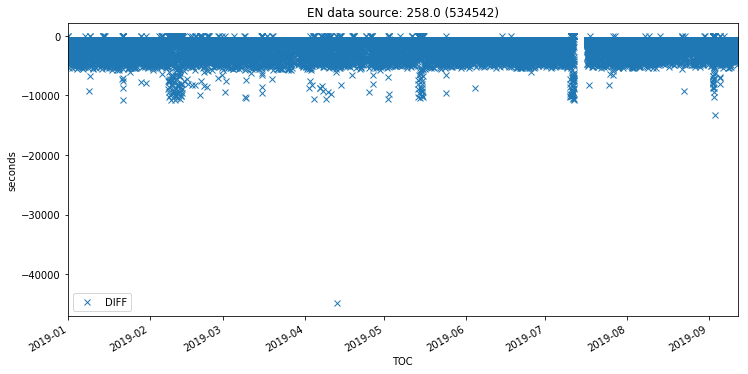

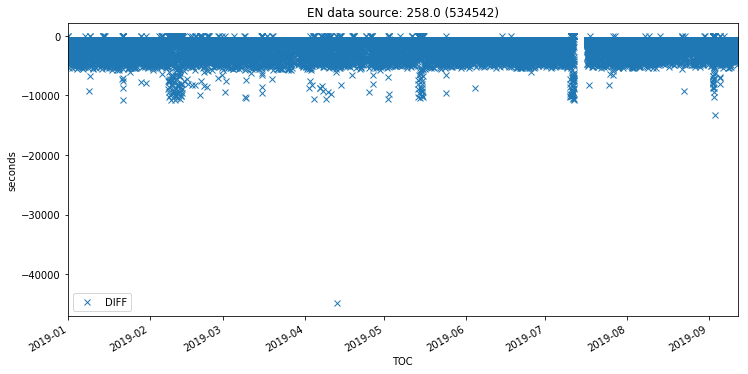

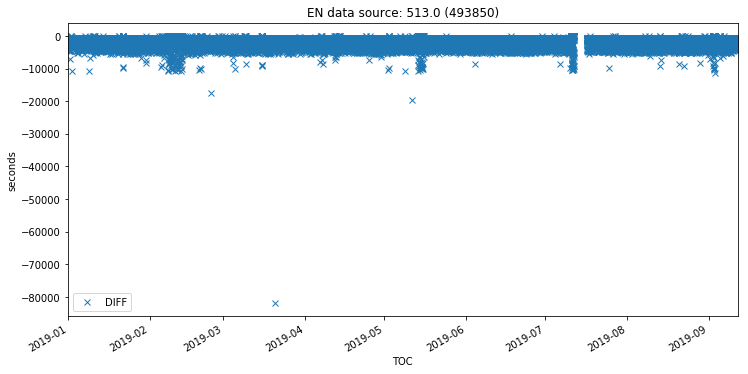

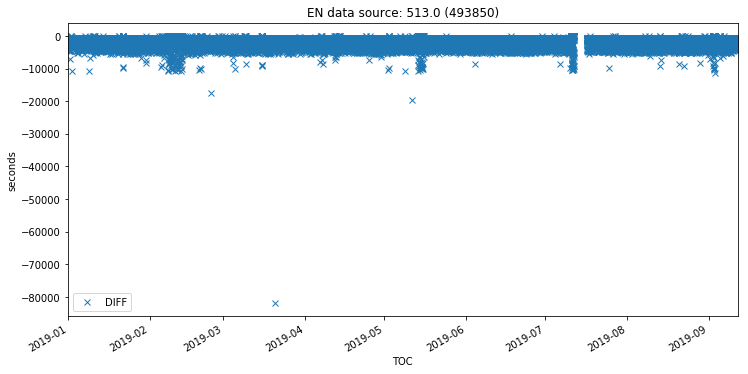

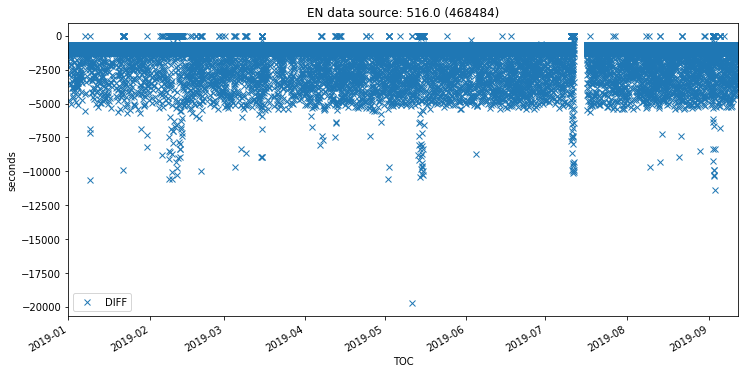

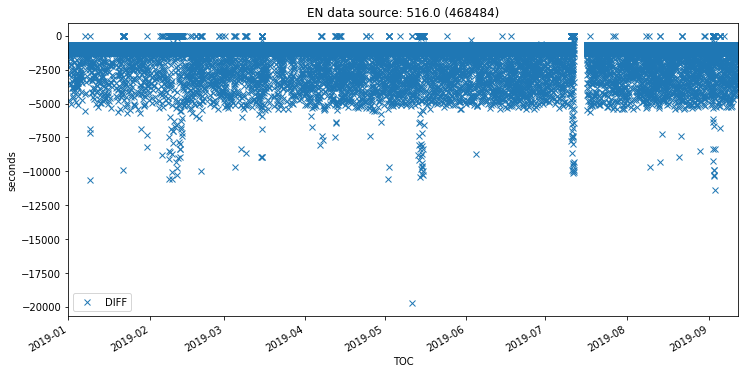

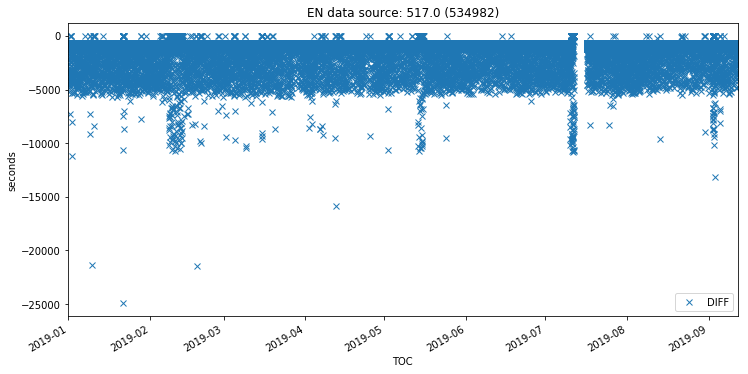

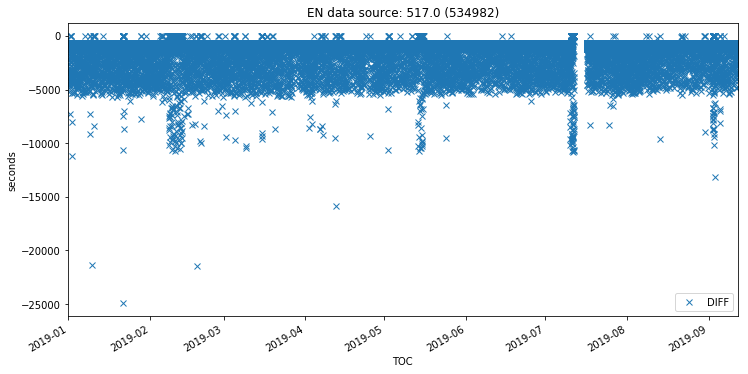

In [14]:
# Is there any difference between the sources?
X = dNAV[~mask].set_index('TOC')[[27, 'DIFF']].groupby(27)
axarr = X.plot(y='DIFF', marker='x', linestyle='None', figsize=(12,6))
[axarr.iloc[i].set(ylabel='seconds', title='EN data source: {} ({})'.format(key, X.get_group(key).shape[0])) 
 for i, key in enumerate(list(X.groups.keys()))];

In [15]:
# statistics
dNAV[~mask].set_index('TOC')[[27, 'DIFF']].groupby(27).describe()

DIFF                                                           
          count        mean         std      min    25%    50%    75%  max
27                                                                        
258.0  534542.0 -817.921810  362.591555 -44830.0 -740.0 -740.0 -740.0  0.0
513.0  493850.0 -760.688189  373.039863 -81805.0 -685.0 -685.0 -685.0 -4.0
516.0  468484.0 -765.466001  328.370559 -19714.0 -694.0 -694.0 -694.0 -4.0
517.0  534982.0 -748.910528  368.480120 -24897.0 -666.0 -665.0 -665.0 -5.0

DIFF                                                           
          count        mean         std      min    25%    50%    75%  max
27                                                                        
258.0  534542.0 -817.921810  362.591555 -44830.0 -740.0 -740.0 -740.0  0.0
513.0  493850.0 -760.688189  373.039863 -81805.0 -685.0 -685.0 -685.0 -4.0
516.0  468484.0 -765.466001  328.370559 -19714.0 -694.0 -694.0 -694.0 -4.0
517.0  534982.0 -748.910528  368.480120 -24897.0 -666.0 -665.0 -665.0 -5.0

In [16]:
# Note: Look at the min and Q3. 

### Closer look to the F/NAV

In [17]:
# Which one have TOE == TTOM?
m = (dNAV[27]==258) & (dNAV['DIFF']==0)
dNAV[m]

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,FNAME,TOC,TOE,TTOM,DIFF,MONTH
427077,E09,2019,2,22,20,40,0,0.006520,-1.136868e-11,0.0,...,506400.0,NaN,NaN,NaN,BRDC00IGS_R_20190530000_01D_MN.rnx.gz,2019-02-22 20:40:00,2019-02-22 20:40:00,2019-02-22 20:40:00,0.0,2
1865527,E25,2019,8,22,22,30,0,0.001702,-1.196554e-11,0.0,...,426600.0,NaN,NaN,NaN,BRDC00IGS_R_20192340000_01D_MN.rnx.gz,2019-08-22 22:30:00,2019-08-22 22:30:00,2019-08-22 22:30:00,0.0,8


,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,FNAME,TOC,TOE,TTOM,DIFF,MONTH
427077,E09,2019,2,22,20,40,0,0.006520,-1.136868e-11,0.0,...,506400.0,NaN,NaN,NaN,BRDC00IGS_R_20190530000_01D_MN.rnx.gz,2019-02-22 20:40:00,2019-02-22 20:40:00,2019-02-22 20:40:00,0.0,2
1865527,E25,2019,8,22,22,30,0,0.001702,-1.196554e-11,0.0,...,426600.0,NaN,NaN,NaN,BRDC00IGS_R_20192340000_01D_MN.rnx.gz,2019-08-22 22:30:00,2019-08-22 22:30:00,2019-08-22 22:30:00,0.0,8


In [18]:
# Shall we remove those which apear as outliers
m = (dNAV[27]==258) & (dNAV['DIFF']<=-3600*3)
dNAV[m]

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,FNAME,TOC,TOE,TTOM,DIFF,MONTH
783120,E14,2019,4,13,2,40,0,-0.000527,-1.442402e-11,0.0,...,572830.0,NaN,NaN,NaN,BRDC00IGS_R_20191030000_01D_MN.rnx.gz,2019-04-13 02:40:00,2019-04-13 02:40:00,2019-04-13 15:07:10,-44830.0,4
1961438,E09,2019,9,3,12,0,0,0.006328,-1.176659e-11,0.0,...,229230.0,NaN,NaN,NaN,BRDC00IGS_R_20192460000_01D_MN.rnx.gz,2019-09-03 12:00:00,2019-09-03 12:00:00,2019-09-03 15:40:30,-13230.0,9


,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,FNAME,TOC,TOE,TTOM,DIFF,MONTH
783120,E14,2019,4,13,2,40,0,-0.000527,-1.442402e-11,0.0,...,572830.0,NaN,NaN,NaN,BRDC00IGS_R_20191030000_01D_MN.rnx.gz,2019-04-13 02:40:00,2019-04-13 02:40:00,2019-04-13 15:07:10,-44830.0,4
1961438,E09,2019,9,3,12,0,0,0.006328,-1.176659e-11,0.0,...,229230.0,NaN,NaN,NaN,BRDC00IGS_R_20192460000_01D_MN.rnx.gz,2019-09-03 12:00:00,2019-09-03 12:00:00,2019-09-03 15:40:30,-13230.0,9


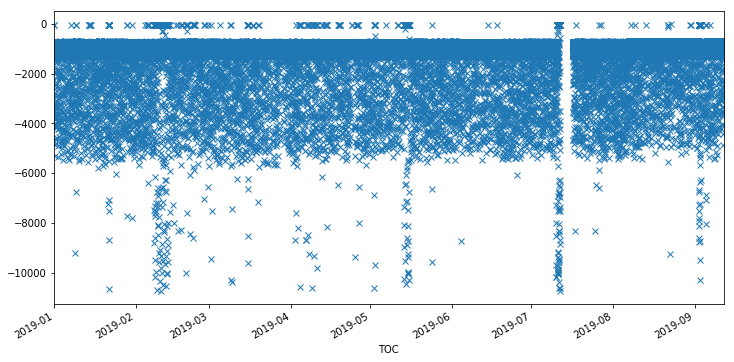

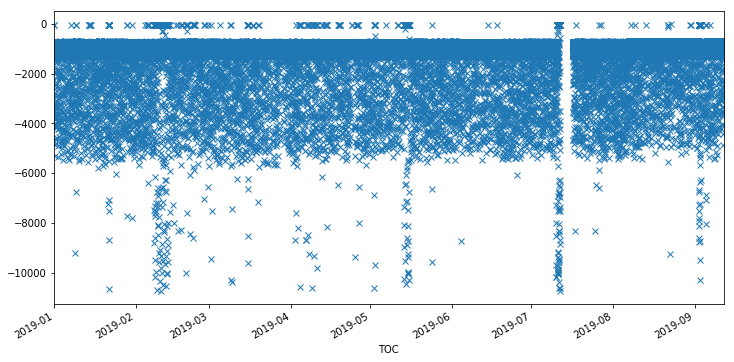

In [19]:
# How does it look without them?
m = (dNAV[27]==258) & (dNAV['DIFF']>-3600*3)
dNAV[m].set_index('TOC')['DIFF'].plot(figsize=(12,6), marker='x', ls='None')

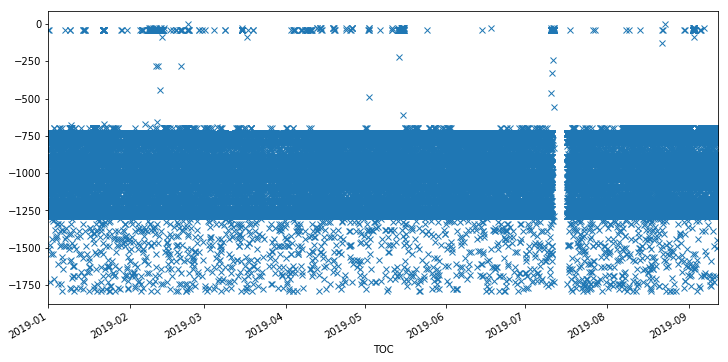

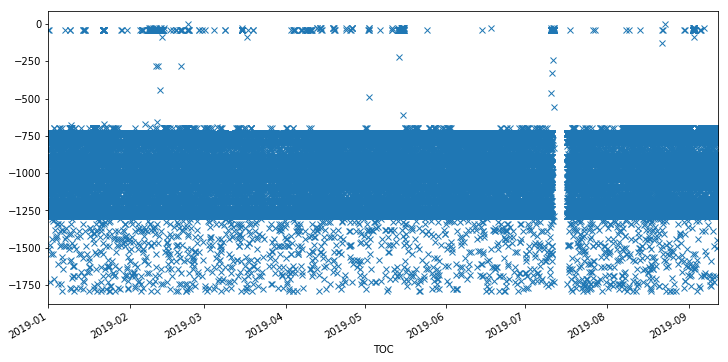

In [20]:
# What if we limit to half an hour?
m = (dNAV[27]==258) & (dNAV['DIFF']>-60*30)
dNAV[m].set_index('TOC')['DIFF'].plot(figsize=(12,6), marker='x', ls='None')

### TOE > TTOM

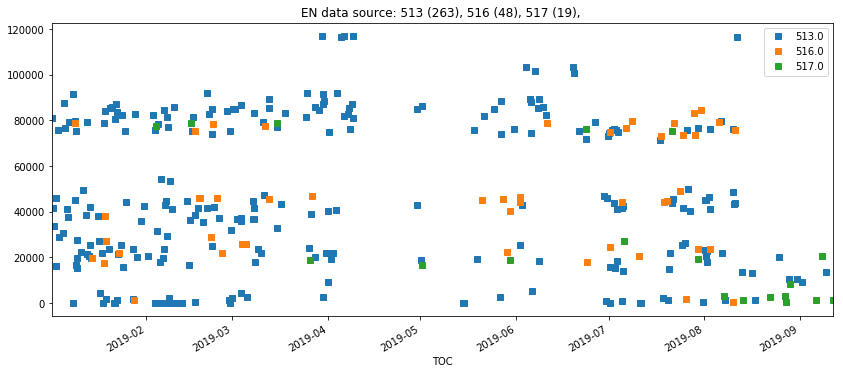

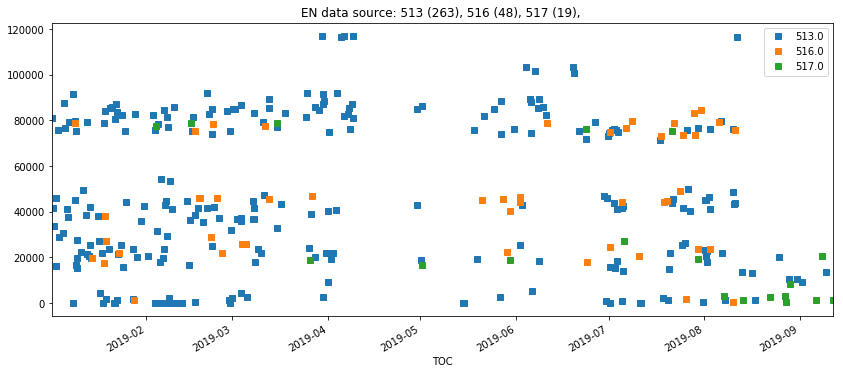

In [21]:
# Now, let's see which TOEs are after TTOMs
fig, ax = plt.subplots(figsize=(14,6))

X=dNAV[mask].set_index('TOC')[[27, 'DIFF']].groupby(27)

title = 'EN data source: '
for key, group in X:
    group.plot(ax=ax, y='DIFF', marker='s', linestyle='None', label=key, legend=False)
    title += '{} ({}), '.format(int(key), group.shape[0])

ax.legend(labels=X.groups.keys())
ax.set_title(title);

In [22]:
# Note: No F/NAV message with TOE > TTOM.

In [23]:
# Most of the TOE is equal to the TOC. Is this an artefact from the BRDC00IGS?
dNAV[dNAV['TOC']!=dNAV['TOE']]

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,FNAME,TOC,TOE,TTOM,DIFF,MONTH
251437,E25,2019,1,31,18,20,0,0.001907,-1.149658e-11,0.0,...,335464.0,NaN,NaN,NaN,BRDC00IGS_R_20190310000_01D_MN.rnx.gz,2019-01-31 18:20:00,2019-01-30 21:00:00,2019-01-30 21:11:04,-664.0,1
620432,E01,2019,3,20,15,10,0,-0.000566,-8.199663e-12,0.0,...,318805.0,NaN,NaN,NaN,BRDC00IGS_R_20190790000_01D_MN.rnx.gz,2019-03-20 15:10:00,2019-03-19 17:50:00,2019-03-20 16:33:25,-81805.0,3
1178269,E31,2019,5,28,7,20,0,-0.000465,-3.126388e-13,0.0,...,123064.0,NaN,NaN,NaN,BRDC00IGS_R_20191480000_01D_MN.rnx.gz,2019-05-28 07:20:00,2019-05-27 10:00:00,2019-05-27 10:11:04,-664.0,5


,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,FNAME,TOC,TOE,TTOM,DIFF,MONTH
251437,E25,2019,1,31,18,20,0,0.001907,-1.149658e-11,0.0,...,335464.0,NaN,NaN,NaN,BRDC00IGS_R_20190310000_01D_MN.rnx.gz,2019-01-31 18:20:00,2019-01-30 21:00:00,2019-01-30 21:11:04,-664.0,1
620432,E01,2019,3,20,15,10,0,-0.000566,-8.199663e-12,0.0,...,318805.0,NaN,NaN,NaN,BRDC00IGS_R_20190790000_01D_MN.rnx.gz,2019-03-20 15:10:00,2019-03-19 17:50:00,2019-03-20 16:33:25,-81805.0,3
1178269,E31,2019,5,28,7,20,0,-0.000465,-3.126388e-13,0.0,...,123064.0,NaN,NaN,NaN,BRDC00IGS_R_20191480000_01D_MN.rnx.gz,2019-05-28 07:20:00,2019-05-27 10:00:00,2019-05-27 10:11:04,-664.0,5


In [24]:
# sample for the first record above
dNAV.groupby(0).get_group('E25').\
groupby(27).get_group(258).\
set_index('TOC')['2019-01-31 18'][[18, 28, 34, 'TOE', 'TTOM']]

,18,28,34,TOE,TTOM
TOC,,,,,
2019-01-31 18:00:00,410400.0,2038.0,411140.0,2019-01-31 18:00:00,2019-01-31 18:12:20
2019-01-31 18:10:00,411000.0,2038.0,411740.0,2019-01-31 18:10:00,2019-01-31 18:22:20
2019-01-31 18:20:00,411600.0,2038.0,412340.0,2019-01-31 18:20:00,2019-01-31 18:32:20


,18,28,34,TOE,TTOM
TOC,,,,,
2019-01-31 18:00:00,410400.0,2038.0,411140.0,2019-01-31 18:00:00,2019-01-31 18:12:20
2019-01-31 18:10:00,411000.0,2038.0,411740.0,2019-01-31 18:10:00,2019-01-31 18:22:20
2019-01-31 18:20:00,411600.0,2038.0,412340.0,2019-01-31 18:20:00,2019-01-31 18:32:20


27
258.0    AxesSubplot(0.125,0.125;0.775x0.755)
513.0    AxesSubplot(0.125,0.125;0.775x0.755)
516.0    AxesSubplot(0.125,0.125;0.775x0.755)
517.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: DIFF, dtype: object

27
258.0    AxesSubplot(0.125,0.125;0.775x0.755)
513.0    AxesSubplot(0.125,0.125;0.775x0.755)
516.0    AxesSubplot(0.125,0.125;0.775x0.755)
517.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: DIFF, dtype: object

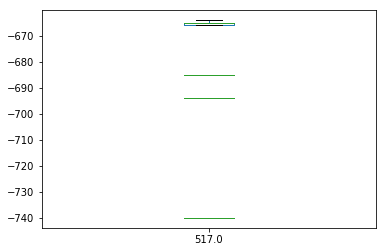

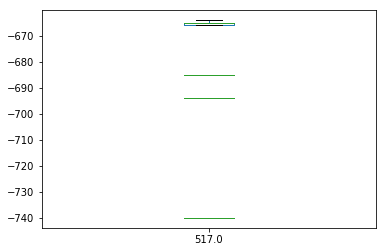

In [25]:
dNAV.groupby(27)['DIFF'].plot(kind='box', showfliers=False)

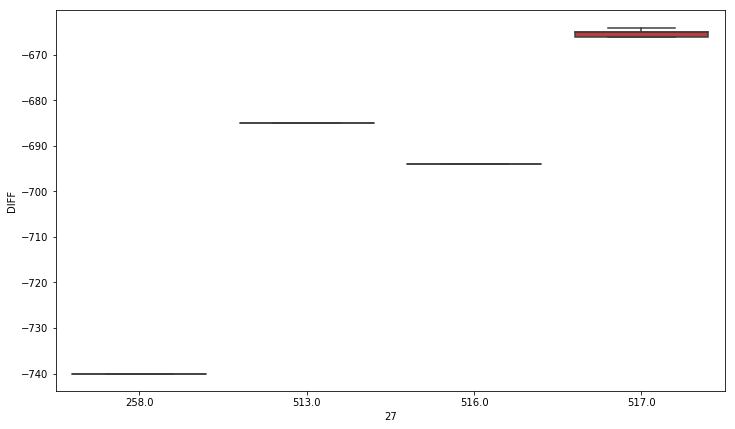

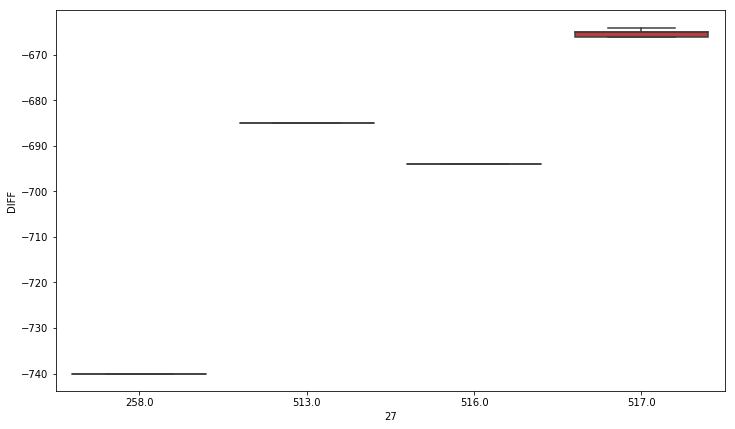

In [26]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,7))
sns.boxplot(x=27, y="DIFF", data=dNAV, showfliers=False, ax=ax)

In [27]:
#dNAV[[0, 27, 'TOC', 'TOE', 'TTOM', 'DIFF']].to_csv('toe_ttom_gal.csv.gz', index=False)

((9332, 43), (9329, 43))

((9332, 43), (9329, 43))

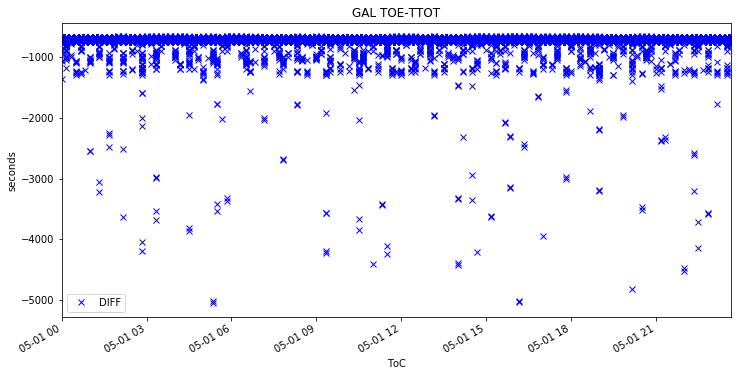

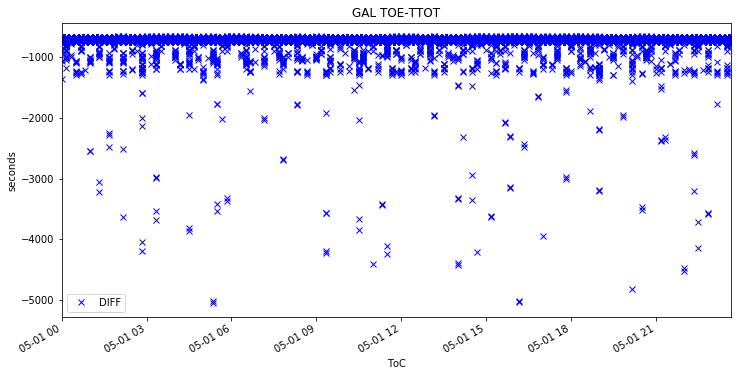

In [28]:
X = dNAV.set_index('TOC')['2019-05-01']
m = X['DIFF']>0

ax = X[~m].plot(y='DIFF', marker='x', linestyle='None', color='b', figsize=(12,6))
#X[m].plot(y='DIFF', marker='s', linestyle='None', color='r', figsize=(12,6), ax=ax)
ax.set(ylabel='seconds', title='GAL TOE-TTOT', xlabel='ToC')
X.shape, X[~m].shape

In [29]:
#fig.savefig('toe_ttom_gal.png', dpi=200, bbox_inches='tight')

In [30]:
# sample of navdata: ToE(sec), GPSweek, TToM (sec), TOE (Timestamp), TTOM (Timestamp)
dNAV.groupby(0).get_group('E25').\
groupby(27).get_group(258).\
set_index('TOC')['2019-05-01'][[18, 28, 34, 'TOE', 'TTOM']].head(6)

,18,28,34,TOE,TTOM
TOC,,,,,
2019-05-01 00:10:00,259800.0,2051.0,260590.0,2019-05-01 00:10:00,2019-05-01 00:23:10
2019-05-01 00:20:00,260400.0,2051.0,261140.0,2019-05-01 00:20:00,2019-05-01 00:32:20
2019-05-01 00:30:00,261000.0,2051.0,261740.0,2019-05-01 00:30:00,2019-05-01 00:42:20
2019-05-01 01:40:00,265200.0,2051.0,266290.0,2019-05-01 01:40:00,2019-05-01 01:58:10
2019-05-01 01:50:00,265800.0,2051.0,266540.0,2019-05-01 01:50:00,2019-05-01 02:02:20
2019-05-01 02:00:00,266400.0,2051.0,267140.0,2019-05-01 02:00:00,2019-05-01 02:12:20


,18,28,34,TOE,TTOM
TOC,,,,,
2019-05-01 00:10:00,259800.0,2051.0,260590.0,2019-05-01 00:10:00,2019-05-01 00:23:10
2019-05-01 00:20:00,260400.0,2051.0,261140.0,2019-05-01 00:20:00,2019-05-01 00:32:20
2019-05-01 00:30:00,261000.0,2051.0,261740.0,2019-05-01 00:30:00,2019-05-01 00:42:20
2019-05-01 01:40:00,265200.0,2051.0,266290.0,2019-05-01 01:40:00,2019-05-01 01:58:10
2019-05-01 01:50:00,265800.0,2051.0,266540.0,2019-05-01 01:50:00,2019-05-01 02:02:20
2019-05-01 02:00:00,266400.0,2051.0,267140.0,2019-05-01 02:00:00,2019-05-01 02:12:20


In [31]:
# Note
# The first navigation message was logged into the receiver at 00:10:00 and the data associated with should be used 
# after 00:23:10 until 00:32:20 when the message logged at 00:20:00 comes into use.
# 
# In a similar fashion, the message which was logged at 00:30:00 contains navigation data to be used after 00:42:20
# all the way until 01:58:20 even though in the meantime two others messages were logged at 01:40:00 and 01:50:00.
